**This is a groovy example of dealing with big catalogs using Pandas.** Here's what it does:
* Read the 3D-HST master catalog
* Filter to a subset of galaxies with given stellar mass and redshift.
* Read in Arjen's catalogs of morphological parameters fit (using Galfit). Concatenate catalogs for each deep field to a single catalog.
* Grab structural parameters (R_e and sersic index) from Arjen's catalogs for the selected objects from the 3D-HST master catalog.  This is easy because Arjen and 3D-HST used the same "phot_ID" = "NUMBER" for each field.  I made a convenience index JRRID that is in common, and unique, between the two tables.  It's just field + ID.
* Plot the results.

In [119]:
%pylab inline
import seaborn as sns
from astropy.io import ascii
from astropy.table import Table
from astropy.io import fits
from astropy.utils.data import download_file
import pandas
from astropy.stats import median_absolute_deviation
from astropy.cosmology import FlatLambdaCDM

Populating the interactive namespace from numpy and matplotlib


In [120]:
%cd /Volumes/Apps_and_Docs/SCIENCE/Deep_Fields/3DHST
%pwd
# Read the 3D-HST master catalog.
#download_file("http://monoceros.astro.yale.edu/RELEASE_V4.1.5/3dhst.v4.1.5.master.fits.gz")
mastercat_file = "3dhst.v4.1.5.master.fits.gz"
pmcat = Table.read(mastercat_file).to_pandas()
# Note, an endian-ness mismatch between FITS and numpy can cause
# gruesome errrors if you import this WRONG way:
#   (mcat, mcat_hdr) = fits.getdata(mastercat_file, header=True)
#   pmcat = pandas.DataFrame.from_records(mcat)  #WRONG
# RIGHT: USE .to_pandas() to avoid this.  See https://github.com/astropy/astropy/issues/1156

/Volumes/Apps_and_Docs/SCIENCE/Deep_Fields/3DHST


In [121]:
print type(pmcat)
pandas.set_option('display.max_columns', 500)  # print all columns in .head()
pmcat.shape

<class 'pandas.core.frame.DataFrame'>


(207967, 215)

In [122]:
# ipython notebook has nice formatting of pandas.head()
pmcat['JRRID'] =  pmcat['field'] + "." + pmcat['phot_id'].astype(str)
pmcat.head()

,phot_id,ra,dec,x,y,grism_id,ifield,field,pointings,npoint,jh_mag,z_spec,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism,z_peak_grism,z_grism_l95,z_grism_l68,z_grism_u68,z_grism_u95,f_cover,f_flagged,max_contam,int_contam,f_negative,flag1,flag2,use_zgrism,use_phot,z_best_s,z_best,z_best_l95,z_best_l68,z_best_u68,z_best_u95,number,linefit_grism_id,linefit_jh_mag,linefit_z_max_grism,s0,s0_err,s1,s1_err,Lya_FLUX,Lya_FLUX_ERR,Lya_SCALE,Lya_EQW,Lya_EQW_ERR,CIV_FLUX,CIV_FLUX_ERR,CIV_SCALE,CIV_EQW,CIV_EQW_ERR,MgII_FLUX,MgII_FLUX_ERR,MgII_SCALE,MgII_EQW,MgII_EQW_ERR,OII_FLUX,OII_FLUX_ERR,OII_SCALE,OII_EQW,OII_EQW_ERR,Hd_FLUX,Hd_FLUX_ERR,Hd_SCALE,Hd_EQW,Hd_EQW_ERR,Hg_FLUX,Hg_FLUX_ERR,Hg_SCALE,Hg_EQW,Hg_EQW_ERR,OIIIx_FLUX,OIIIx_FLUX_ERR,OIIIx_SCALE,OIIIx_EQW,OIIIx_EQW_ERR,HeII_FLUX,HeII_FLUX_ERR,HeII_SCALE,HeII_EQW,HeII_EQW_ERR,Hb_FLUX,Hb_FLUX_ERR,Hb_SCALE,Hb_EQW,Hb_EQW_ERR,OIII_FLUX,OIII_FLUX_ERR,OIII_SCALE,OIII_EQW,OIII_EQW_ERR,Ha_FLUX,Ha_FLUX_ERR,Ha_SCALE,Ha_EQW,Ha_EQW_ERR,SII_FLUX,SII_FLUX_ERR,SII_SCALE,SII_EQW,SII_EQW_ERR,SIII_FLUX,SIII_FLUX_ERR,SIII_SCALE,SIII_EQW,SIII_EQW_ERR,HeI_FLUX,HeI_FLUX_ERR,HeI_SCALE,HeI_EQW,HeI_EQW_ERR,HeIb_FLUX,HeIb_FLUX_ERR,HeIb_SCALE,HeIb_EQW,HeIb_EQW_ERR,NeIII_FLUX,NeIII_FLUX_ERR,NeIII_SCALE,NeIII_EQW,NeIII_EQW_ERR,NeV_FLUX,NeV_FLUX_ERR,NeV_SCALE,NeV_EQW,NeV_EQW_ERR,NeVI_FLUX,NeVI_FLUX_ERR,NeVI_SCALE,NeVI_EQW,NeVI_EQW_ERR,OI_FLUX,OI_FLUX_ERR,OI_SCALE,OI_EQW,OI_EQW_ERR,id_3,rf_z_best,z_type_3,rf_z_spec,DM,L153,nfilt153,L154,nfilt154,L155,nfilt155,L161,nfilt161,L162,nfilt162,L163,nfilt163,L156,nfilt156,L157,nfilt157,L158,nfilt158,L159,nfilt159,L160,nfilt160,L135,nfilt135,L136,nfilt136,L137,nfilt137,L138,nfilt138,L139,nfilt139,L270,nfilt270,L271,nfilt271,L272,nfilt272,L273,nfilt273,L274,nfilt274,L275,nfilt275,id_4,sfr,sfr_IR,sfr_UV,L_IR,L_UV,flag,sfr_z_best,z_type_4,f24tot,ef24tot,L_1600,L_2800,beta,id_5,z,ltau,metal,lage,Av,lmass,lsfr,lssfr,la2t,chi2,JRRID
0,1,215.222382,53.004185,9590.5,3057.3,00000,1,aegis,--,0,13.9635,-1.0,0.0100,0.010,0.011,0.024,0.025,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00,-1.00,-1.00,-1.00,-1.0,-1,-1,0,0,0,-1.0000,-1.000,-1.000,-1.000,-1.000,1,00000,13.9635,-1.00000,0.000,0.000,0.000,0.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.000,-99.00,-99.00,-99.00,-99.00,-99.000,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1,0.0100,0,-1.0,33.17,1408.710000,2,2346.100000,3,2362.280000,3,23684.70000,5,29296.60000,4,20131.90000,0,1299.190000,2,2261.400000,4,2570.710000,4,3075.86000,5,4460.900000,4,1378.700000,2,2346.760000,3,2364.400000,3,2413.610000,4,3407.790000,3,39.857800,0,56.403000,0,102.062000,0,238.947000,1,270.328000,1,2313.550000,3,1,0.021714,0.000308,0.021406,2.826800e+06,8.926600e+07,0,0.0100,0,173.100,17.39,19605000.0,5.951100e+07,0.38,1,0.01,7.8,0.02,7.6,1.1,7.51,-0.16,-7.67,-0.2,57.000,aegis.1
1,2,215.096588,52.918053,16473.2,3150.2,aegis-26-G141_00002,1,aegis,26,1,18.8730,-1.0,0.0100,0.010,0.011,0.024,0.025,1.39768,1.39842,1.39461,1.39591,1.39993,1.40319,0.36,0.13,0.62,0.43,0.0,0,1,0,0,3,0.0100,0.010,0.011,0.024,0.025,2,aegis-26-G141_00002,18.8730,1.39768,2.072,0.033,1.093,0.232,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.23,26.68,0.16,19.82,16.81,34.18,23.27,0.154,26.04,17.89,31.51,24.36,0.149,20.17,15.78,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-

In [123]:
# Read in Arjen's catalogs of morphological parameters, for each field
#download_file("http://www.mpia-hd.mpg.de/homes/vdwel/allfields.tar")
# mkdir VanderWel; cd VanderWel; tar -xvf allfields.tar
# I then edited by hand the headers, stripping out the initial "#  "
vdw_H_files = ("VanderWel/aegis/aegis_3dhst.v4.1_f125w.galfit", "VanderWel/goodss/goodss_3dhst.v4.1_f125w.galfit", "VanderWel/cosmos/cosmos_3dhst.v4.1_f125w.galfit", "VanderWel/uds/uds_3dhst.v4.1_f125w.galfit", "VanderWel/goodsn/goodsn_3dhst.v4.1_f125w.galfit")
vdw_fields = ('aegis', 'goodss', 'cosmos', 'uds', 'goodsn')
vdw_df = {}
for ii, label in enumerate(vdw_fields):
    vdw_df[label] = pandas.read_table(vdw_H_files[ii], delim_whitespace=True, comment="#", header=0)
    vdw_df[label]['field'] = vdw_fields[ii]
    vdw_df[label]['JRRID'] = vdw_fields[ii] + '.' + vdw_df[label]['NUMBER'].astype(str)
vdw_all = pandas.concat(vdw_df)


In [124]:
vdw_all.tail()

NUMBER         RA       DEC  f       mag        dmag         re  \
uds 44097   44098  34.363106 -5.122066  3 -999.0000 -999.000000 -999.00000   
    44098   44099  34.333569 -5.123219  3 -999.0000 -999.000000 -999.00000   
    44099   44100  34.363682 -5.123124  3 -999.0000 -999.000000 -999.00000   
    44100   44101  34.556389 -5.123040  2   21.8374    0.129177    0.79842   
    44101   44102  34.365097 -5.121975  3 -999.0000 -999.000000 -999.00000   

                  dre         n          dn         q          dq       pa  \
uds 44097 -999.000000 -999.0000 -999.000000 -999.0000 -999.000000 -999.000   
    44098 -999.000000 -999.0000 -999.000000 -999.0000 -999.000000 -999.000   
    44099 -999.000000 -999.0000 -999.000000 -999.0000 -999.000000 -999.000   
    44100    0.082741    0.2012    0.097413    0.0872    0.071283   59.108   
    44101 -999.000000 -999.0000 -999.000000 -999.0000 -999.000000 -999.000   

                 dpa       sn field      JRRID  
uds 44097 -999.00000   0.0000   uds  uds.44098  
    44098 -999.00000   0.0000   uds  uds.44099  
    44099 -999.00000   0.0000   uds  uds.44100  
    44100    5.30492  16.0617   uds  uds.44101  
    44101 -999.00000   0.0000   uds  uds.44102

JRRID is field.ID, so should be able to directly compare pandas data frames pmcat and vdw_all.
Now, PANDAS MAGIC, I will re-index by JRRID, and then I can filter at will!

In [125]:
pmcat_jrr   = pmcat.set_index('JRRID')
vdw_all_jrr= vdw_all.set_index('JRRID')

In [126]:
# Filter on redshift and M*
zlo = 2.0
zhi = 3.0
Mlo = 9.0
Mhi = 9.5
# This filtering works b/c I re-indexed arrays by unique index 'JRRID'. 
# If I weren't already a fan of pandas, this would sell me.  filt1 and filt2 are filters
# created from the first and second catalogs, respectively, and while they have different
# shapes, Pandas can do math on them (in this case, boolean and), because their indexes
# are in common.  This makes a difficult matching (catalogs of different sizes) easy.
filt1 = pmcat_jrr['z_best'].between(zlo,zhi) & pmcat_jrr['lmass'].between(Mlo,Mhi)
print pmcat_jrr[filt1].shape #both
print vdw_all_jrr[filt1].shape
filt2 = vdw_all_jrr['f'].eq(0)   # Filter on a good Galfit fit
#filt2 = vdw_all_jrr['f'].eq(0) | vdw_all_jrr['f'].eq(1)  # Kate wants this checked***
filt = filt1 & filt2   # Require galaxy in M*/z selection, and a good Galfit
print vdw_all_jrr[filt2].shape, "N with good galfit"
print vdw_all_jrr[filt].shape, "N with good M*, z, galfit:"

(8065, 215)
(8065, 16)
(94135, 16) N with good galfit
(3597, 16) N with good M*, z, galfit:


In [127]:
# Calculate angular diameter distances for WMAP cosmology.  Want to use to translate re from arcsec in to kpc
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
pmcat_jrr['angdiamD'] = cosmo.angular_diameter_distance(pmcat_jrr['z_best']).value / 206265 * 1000.  # kpc per arcsec

In [128]:
# Add a point I want to plot
kpc_per_arcsec = 8.085
# add in s1110          r_e(")          n     d(r_e("))        d(n)
s1110_candelized= (2.3, 1.0, 0.3, 0.4)   # average over all bands
s1110_F160cand = (0.32*kpc_per_arcsec, 0.68, 0.029*kpc_per_arcsec, 0.26)   #F160W only, from last row, Table 1 of paper draft
def plot_my_point() :
    plt.scatter( s1110_candelized[0]/kpc_per_arcsec, s1110_candelized[1], color='k', s=100)
    plt.errorbar(s1110_candelized[0]/kpc_per_arcsec,s1110_candelized[1], xerr=s1110_candelized[2]/kpc_per_arcsec,yerr=s1110_candelized[3], ecolor='k')
    plt.scatter( s1110_F160cand[0]/kpc_per_arcsec, s1110_F160cand[1], color='r', s=100)
    plt.errorbar(s1110_F160cand[0]/kpc_per_arcsec,s1110_F160cand[1], xerr=s1110_F160cand[2]/kpc_per_arcsec,yerr=s1110_F160cand[3], ecolor='r')
    return(0)
def plot_my_point_kpc() :
    plt.scatter( s1110_candelized[0], s1110_candelized[1], color='k', s=100)
    plt.errorbar(s1110_candelized[0],s1110_candelized[1], xerr=s1110_candelized[2],yerr=s1110_candelized[3], ecolor='k')
    plt.scatter( s1110_F160cand[0], s1110_F160cand[1], color='r', s=100)
    plt.errorbar(s1110_F160cand[0],s1110_F160cand[1], xerr=s1110_F160cand[2],yerr=s1110_F160cand[3], ecolor='r')
    return(0)

median, mad: 1.70240994 0.72401175
s1110 R_e, std: 2.5872 0.234465


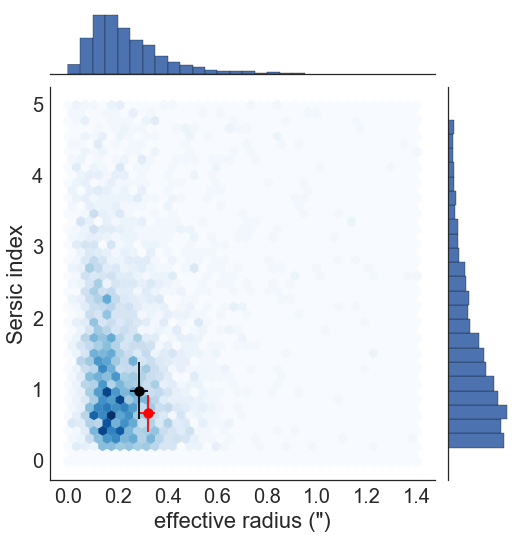

In [129]:
# Let's try the seaborn JointGrid, to add histograms to margins
# code borrowed from https://github.com/mwaskom/seaborn/issues/469
sns.set(font_scale=2)
sns.set_style("white")
plotted = vdw_all_jrr[filt]
print "median, mad:", plotted.re.median()*kpc_per_arcsec, mad(plotted.re)*kpc_per_arcsec
print "s1110 R_e, std:", s1110_F160cand[0], s1110_F160cand[2]
g = sns.JointGrid(plotted.re, plotted.n, size=8)
g.set_axis_labels("effective radius (\")", "Sersic index")
g.ax_marg_x.hist(plotted.re, bins=np.arange(0, 1.0, 0.05))
g.ax_marg_y.hist(plotted.n, bins=np.arange(0, 5, 0.2), orientation="horizontal")
g.plot_joint(plt.hexbin, gridsize=40, extent=[0, 1.4, 0, 5], cmap="Blues")
plot_my_point()  # cool, I can overplot regular matplotlib commands like scatter, errorbar
g.fig.savefig("filter_hex.pdf")

median, mad R_e: 1.70587432733 0.721503010277 (kpc)
s1110 R_e, std: 2.5872 0.234465


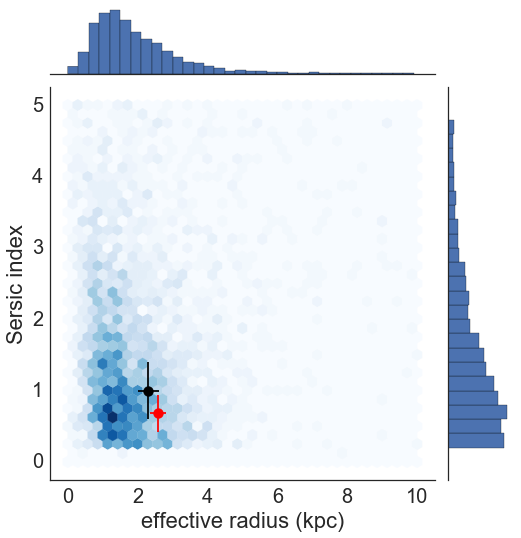

In [130]:
# Again, but with x-axis as angular diameter distance (kpc)
rekpc = vdw_all_jrr['re'][filt] * pmcat_jrr['angdiamD'][filt]   #Re in kpc
print "median, mad R_e:", rekpc.median(), mad(rekpc), "(kpc)"
print "s1110 R_e, std:", s1110_F160cand[0], s1110_F160cand[2]
gg = sns.JointGrid(rekpc, plotted.n, size=8)
gg.set_axis_labels("effective radius (kpc)", "Sersic index")
gg.ax_marg_x.hist(rekpc, bins=np.arange(0, 10., 0.3))
gg.ax_marg_y.hist(plotted.n, bins=np.arange(0, 5, 0.2), orientation="horizontal")
gg.plot_joint(plt.hexbin, gridsize=35, extent=[0, 10, 0, 5], cmap="Blues")
plot_my_point_kpc()  
gg.fig.savefig("filter_hex_kpc.pdf")